<a href="https://colab.research.google.com/github/junduk123/Machine-Learning-Task/blob/main/Task14/Bidirectional_RNN_Model_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Untuk mengabilkan dataset dari google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-5-ea846da2fef2>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['wip'].fillna(data['wip'].median(), inplace=True)


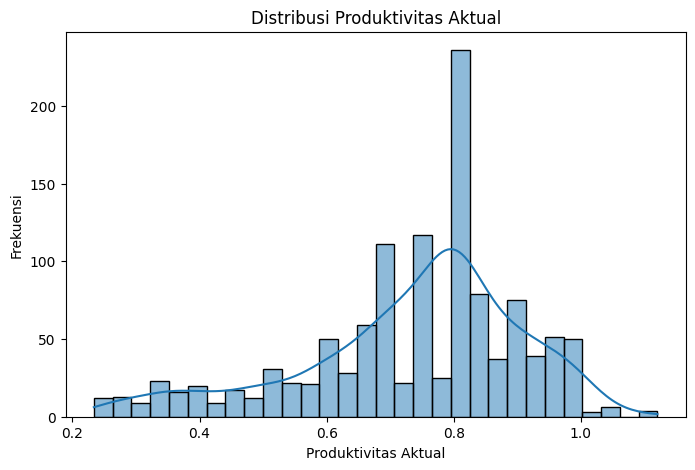

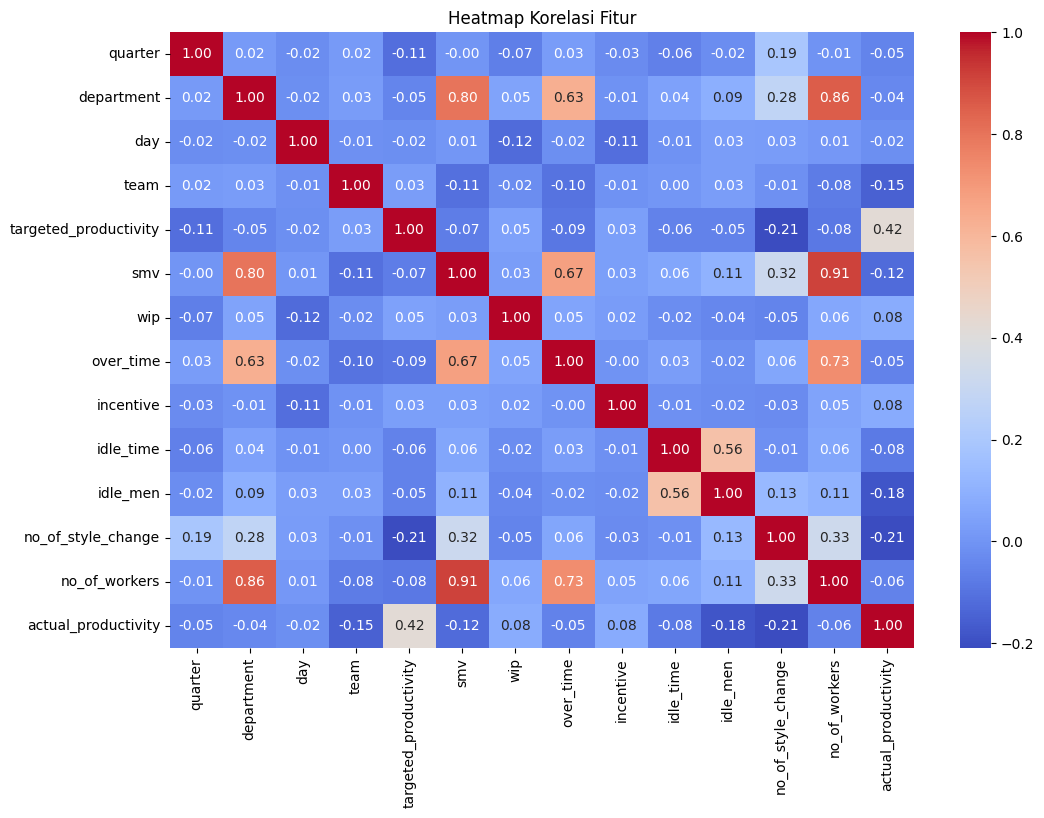

Streaming output truncated to the last 5000 lines.
Epoch [52/350], Train Loss: 0.0196, Test Loss: 0.0186
Epoch [53/350], Train Loss: 0.0194, Test Loss: 0.0186
Epoch [54/350], Train Loss: 0.0197, Test Loss: 0.0180
Epoch [55/350], Train Loss: 0.0196, Test Loss: 0.0182
Epoch [56/350], Train Loss: 0.0194, Test Loss: 0.0177
Epoch [57/350], Train Loss: 0.0195, Test Loss: 0.0176
Epoch [58/350], Train Loss: 0.0196, Test Loss: 0.0176
Epoch [59/350], Train Loss: 0.0194, Test Loss: 0.0176
Epoch [60/350], Train Loss: 0.0195, Test Loss: 0.0174
Epoch [61/350], Train Loss: 0.0193, Test Loss: 0.0178
Epoch [62/350], Train Loss: 0.0200, Test Loss: 0.0181
Epoch [63/350], Train Loss: 0.0190, Test Loss: 0.0175
Epoch [64/350], Train Loss: 0.0189, Test Loss: 0.0184
Epoch [65/350], Train Loss: 0.0191, Test Loss: 0.0170
Epoch [66/350], Train Loss: 0.0188, Test Loss: 0.0173
Epoch [67/350], Train Loss: 0.0188, Test Loss: 0.0177
Epoch [68/350], Train Loss: 0.0187, Test Loss: 0.0169
Epoch [69/350], Train Loss: 0.0

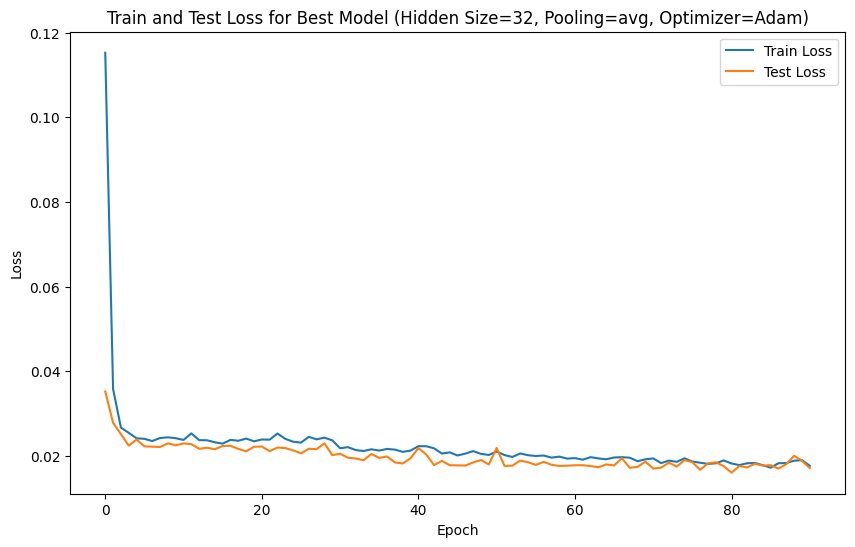

R-squared (Akurasi): 0.3738


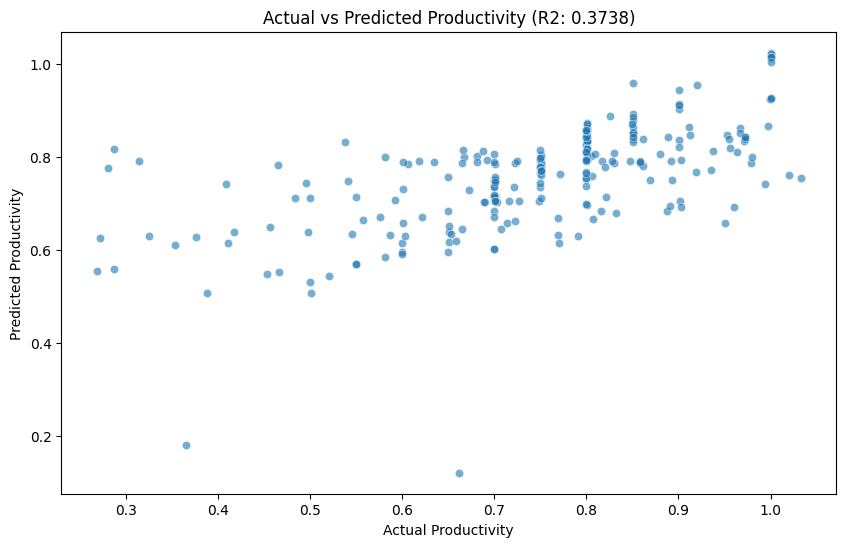

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Memuat dataset
data = pd.read_csv("/content/drive/MyDrive/Bidirectional RNN Model/garments_worker_productivity.csv")

# Menghapus kolom 'date' karena tidak relevan untuk model numerik
data.drop(columns=['date'], inplace=True)

# 1. Pra-pemrosesan Data dan EDA
# Mengisi nilai kosong pada kolom 'wip' dengan median
data['wip'].fillna(data['wip'].median(), inplace=True)

# Mengonversi data kategorikal menjadi numerik menggunakan LabelEncoder
categorical_cols = ['quarter', 'department', 'day']
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    data[col] = label_encoders[col].fit_transform(data[col])

# Visualisasi distribusi target
plt.figure(figsize=(8, 5))
sns.histplot(data['actual_productivity'], kde=True, bins=30)
plt.title('Distribusi Produktivitas Aktual')
plt.xlabel('Produktivitas Aktual')
plt.ylabel('Frekuensi')
plt.savefig('/content/drive/MyDrive/Bidirectional RNN Model/distribution_actual_productivity.png')
plt.show()

# Visualisasi korelasi fitur numerik
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Heatmap Korelasi Fitur')
plt.savefig('/content/drive/MyDrive/Bidirectional RNN Model/feature_correlation_heatmap.png')
plt.show()

# Menormalisasi data numerik menggunakan StandardScaler
numerical_cols = ['targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
                  'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Membagi dataset menjadi fitur (X) dan target (y)
X = data[categorical_cols + numerical_cols]
y = data['actual_productivity']

# Membagi data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menambahkan dimensi sequence pada data input
X_train = X_train.values[:, None, :]
X_test = X_test.values[:, None, :]

# Mengonversi data menjadi tensor PyTorch
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Definisi Model Bidirectional RNN
class BidirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, pooling_type):
        super(BidirectionalRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.pooling_type = pooling_type
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 karena bidirectional

    def forward(self, x):
        h0 = torch.zeros(self.rnn.num_layers * 2, x.size(0), self.rnn.hidden_size).to(x.device)  # Hidden state awal
        out, _ = self.rnn(x, h0)  # Output RNN
        if self.pooling_type == 'max':
            out, _ = torch.max(out, dim=1)  # MaxPooling
        elif self.pooling_type == 'avg':
            out = torch.mean(out, dim=1)  # AvgPooling
        out = self.fc(out)  # Fully connected layer
        return out

# Fungsi untuk melatih model
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, early_stopping_patience):
    train_losses, test_losses = [], []
    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Evaluasi model pada data uji
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                test_loss += loss.item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # Early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

    return train_losses, test_losses

# Hyperparameter
input_size = X_train.shape[2]  # Jumlah fitur input
output_size = 1  # Output adalah nilai produktivitas
hidden_sizes = [32, 64, 128]  # Variasi ukuran hidden layer
num_layers = 2
pooling_types = ['max', 'avg']  # Variasi pooling
optimizers = [optim.SGD, optim.RMSprop, optim.Adam]  # Variasi optimizer
num_epochs_list = [5, 50, 100, 250, 350]  # Variasi jumlah epoch

# Loop untuk mencoba berbagai kombinasi hyperparameter
results = []
for hidden_size in hidden_sizes:
    for pooling_type in pooling_types:
        for optimizer_fn in optimizers:
            for num_epochs in num_epochs_list:
                print(f"Training model with Hidden Size={hidden_size}, Pooling={pooling_type}, Optimizer={optimizer_fn.__name__}, Epochs={num_epochs}")

                model = BidirectionalRNN(input_size, hidden_size, num_layers, output_size, pooling_type)
                criterion = nn.MSELoss()
                optimizer = optimizer_fn(model.parameters(), lr=0.001)

                train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, early_stopping_patience=10)

                results.append({
                    'hidden_size': hidden_size,
                    'pooling': pooling_type,
                    'optimizer': optimizer_fn.__name__,
                    'epochs': num_epochs,
                    'final_train_loss': train_losses[-1],
                    'final_test_loss': test_losses[-1]
                })

# Sort hasil berdasarkan test loss terbaik
sorted_results = sorted(results, key=lambda x: x['final_test_loss'])[:5]

# Menampilkan 5 hasil terbaik
print("\nTop 5 Configurations:")
for res in sorted_results:
    print(res)

# Simpan hasil ke CSV
results_df = pd.DataFrame(results)
results_df.to_csv('/content/drive/MyDrive/Bidirectional RNN Model/training_results.csv', index=False)

# Visualisasi loss untuk konfigurasi terbaik
best_model_config = sorted_results[0]
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Train and Test Loss for Best Model (Hidden Size={best_model_config['hidden_size']}, Pooling={best_model_config['pooling']}, Optimizer={best_model_config['optimizer']})")
plt.legend()
plt.savefig('/content/drive/MyDrive/Bidirectional RNN Model/loss_visualization_best_model.png')
plt.show()

# Visualisasi distribusi hasil prediksi vs aktual dan akurasi
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        predictions.extend(outputs.numpy())
        actuals.extend(y_batch.numpy())

# Hitung r-squared sebagai akurasi
r2 = r2_score(actuals, predictions)
print(f"R-squared (Akurasi): {r2:.4f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=actuals, y=predictions, alpha=0.6)
plt.xlabel('Actual Productivity')
plt.ylabel('Predicted Productivity')
plt.title(f'Actual vs Predicted Productivity (R2: {r2:.4f})')
plt.savefig('/content/drive/MyDrive/Bidirectional RNN Model/actual_vs_predicted_scatter.png')
plt.show()
